# Steps for [tensorflow/tensorflow:latest-jupyter](https://hub.docker.com/r/tensorflow/tensorflow)

## For pip
- --upgrade pip
- sklearn
- opencv-python
- imutils

## For the OS
- apt-get update
- apt-get install libsm6 libxext6 ffmpeg -y

In [2]:
# Import Keras Stuff
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

In [3]:
# Other Stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline
import matplotlib.pyplot as plt
from cv2 import imread, resize
from imutils import paths
import seaborn as sns
import numpy as np
import os

In [4]:
# Learning rate, number of epochs and batch size
EPOCHS = 20
LR = 1e-4
BS = 32

In [5]:
# Variables for loading all the images
image_paths = list(paths.list_images('thermal_dataset'))
dataset_folder = os.listdir('thermal_dataset')
dataset_sizes = [len(os.listdir('thermal_dataset/'+folder)) for folder in dataset_folder]
data = []
labels = [] 

In [6]:
image = imread(image_paths[0])
h, w = image.shape[:2]
start_X, start_y, end_X, end_y = 10, 0, w - 11, h - 1

In [7]:
%%time
for image_path in image_paths:
    # extract the class label from the filename
    label = image_path.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = imread(image_path)[start_y:end_y,start_X:end_X]
    image = resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

CPU times: user 396 ms, sys: 199 ms, total: 594 ms
Wall time: 591 ms


In [8]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


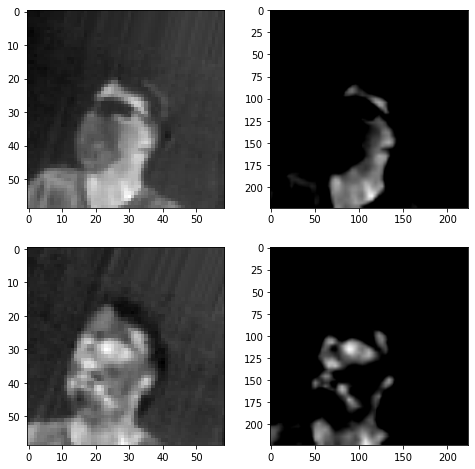

In [9]:
fig, axis = plt.subplots(2, 2, figsize=(8, 8))
axis[0,1].imshow(data[0])
axis[1,1].imshow(data[dataset_sizes[0]])
axis[0,0].imshow(imread(image_paths[0])[start_y:end_y,start_X:end_X])
axis[1,0].imshow(imread(image_paths[dataset_sizes[0]])[start_y:end_y,start_X:end_X])

In [10]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [11]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(X_train, X_test, y_train, y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


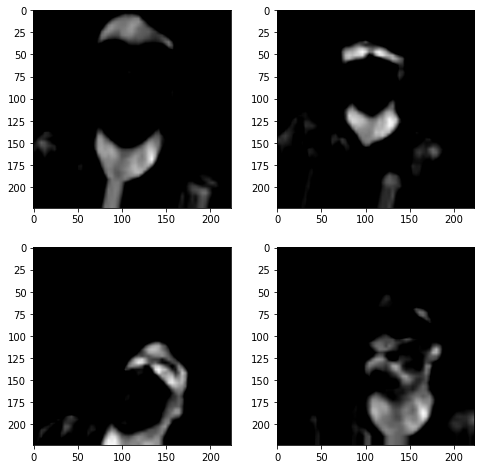

In [12]:
fig, axis = plt.subplots(2, 2, figsize=(8, 8))
axis[0,1].imshow(X_train[0])
axis[1,1].imshow(X_train[-1])
axis[0,0].imshow(X_test[0])
axis[1,0].imshow(X_test[-1])

In [13]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [14]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
base_model = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 2s 0us/step


In [15]:
# construct the head of the model that will be placed on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

In [16]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model.input, outputs=head_model)

In [17]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

In [18]:
# compile our model
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [19]:
%%time
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

Epoch 1/2
23/23 [==============================] - 104s 4s/step - loss: 0.6746 - accuracy: 0.6531 - val_loss: 0.4498 - val_accuracy: 0.8824
Epoch 2/2
23/23 [==============================] - 206s 9s/step - loss: 0.4591 - accuracy: 0.8098 - val_loss: 0.2692 - val_accuracy: 0.9840
CPU times: user 23min 15s, sys: 5min 56s, total: 29min 11s
Wall time: 5min 9s


In [20]:
# make predictions on the testing set
y_score = model.predict(X_test, batch_size=BS)

In [21]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predicts = np.argmax(y_score, axis=1)

In [22]:
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predicts,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98        93
without_mask       0.99      0.98      0.98        94

    accuracy                           0.98       187
   macro avg       0.98      0.98      0.98       187
weighted avg       0.98      0.98      0.98       187



<AxesSubplot:>

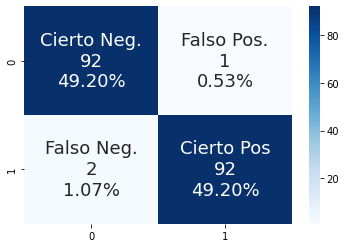

In [23]:
# show a nicely formatted confusion matrix
cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_score.argmax(axis=1))
group_names = ['Cierto Neg.','Falso Pos.','Falso Neg.','Cierto Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":18})

In [24]:
# serialize the model to disk
model.save('thermal_mask_detector.model', save_format="h5")

/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
# plot the training loss and accuracy
def make_graph(axis, x, y1, y2, label_1, label_2, title, x_label, y_label):
    line_1, = axis.plot(x, y1)
    line_1.set_label(label_1)
    line_2, = axis.plot(x, y2)
    line_2.set_label(label_2)
    axis.legend()
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    return ax1, ax2

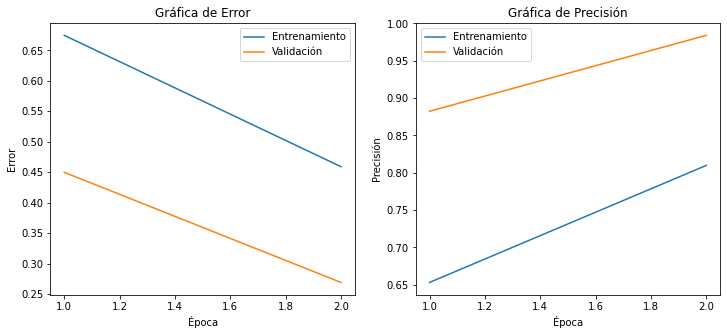

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
make_graph(ax1, np.arange(1, EPOCHS + 1), H.history["loss"], H.history["val_loss"], 'Entrenamiento', 'Validación', 'Gráfica de Error', 'Época', 'Error')
make_graph(ax2, np.arange(1, EPOCHS + 1), H.history["accuracy"], H.history["val_accuracy"], 'Entrenamiento', 'Validación', 'Gráfica de Precisión', 'Época', 'Precisión')
plt.savefig("thermal_training_plot.jpg")
plt.show()

In [27]:
H.history["accuracy"][-1]

0.8097901940345764

In [28]:
H.history["val_accuracy"][-1]

0.9839572310447693